In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats


In [2]:
#recupération de la variable 

df_clean = pd.read_pickle('df_clean.pkl')

df_clean

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Normalisation du jeu de données

In [3]:
df_clean['smoker']= (df_clean['smoker']=="yes").astype(int)
df_clean['sex']= (df_clean['sex']=='male').astype(int)
for region in df_clean['region'].unique():
    r = f'is_{region}'
    df_clean[r] = 0
    df_clean.loc[df_clean['region'] == region, r] = 1
df_clean.drop('region', axis=1, inplace=True)
df_clean

,age,sex,bmi,children,smoker,charges,is_southwest,is_southeast,is_northwest,is_northeast
0,19,0,27.900,0,1,16884.92400,1,0,0,0
1,18,1,33.770,1,0,1725.55230,0,1,0,0
2,28,1,33.000,3,0,4449.46200,0,1,0,0
3,33,1,22.705,0,0,21984.47061,0,0,1,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,0,1,0
1334,18,0,31.920,0,0,2205.98080,0,0,0,1
1335,18,0,36.850,0,0,1629.83350,0,1,0,0
1336,21,0,25.800,0,0,2007.94500,1,0,0,0


<Axes: >

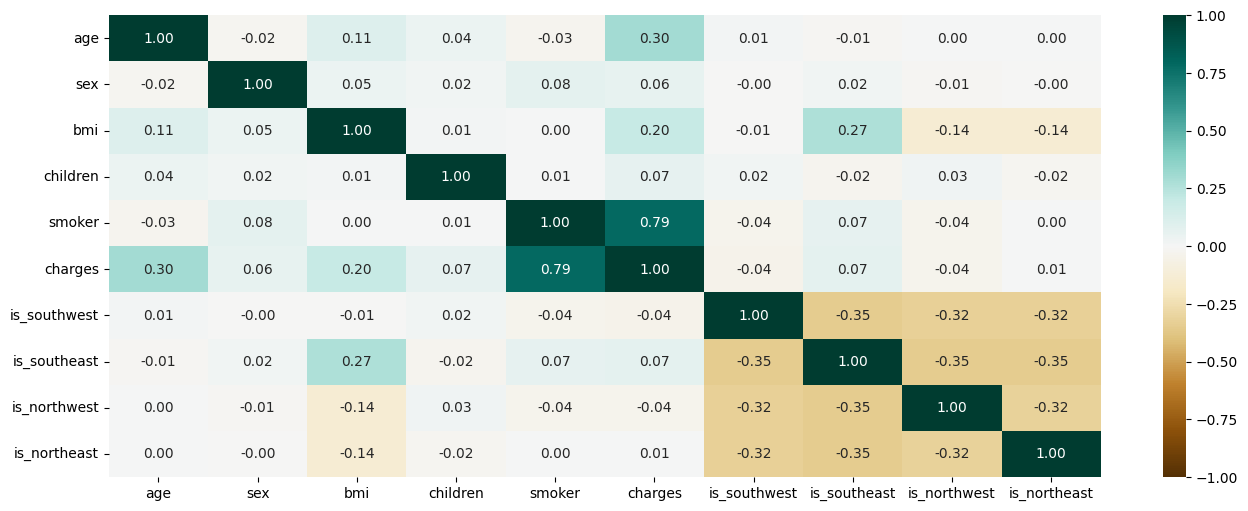

In [4]:

plt.figure(figsize=(16, 6))
sns.heatmap(df_clean.corr(method='pearson'), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='BrBG')

Nous remarquons plusieurs correlations avec la target :
- charges/smoke 0.79
- charges/age 0.3
- charges/bmi 0.20

De plus, nous observons une corrélation entre deu variables "indépendantes":
- region southeast/bmi

Par conséquent, nous procéderons de la manière suivante:

- Représentation ScatterPlot pour l'annalyse charges/age et charges/bmi
- Confirmation de la relation via Anova pour charges/smoke et region southeast/bmi






# Catégorisation de bmi et age

In [5]:
# catégorisation des ages
intervals = [(18, 35, 1), (36, 50, 2), (51, 70, 3), (71, 200, 4)]
df_clean['age_cat'] = pd.Series()

for interval in intervals:
    min, max, name = interval
    col = f'{min}_{max}'
    df_clean[col] = 0
    df_clean.loc[(df_clean.age >= min) & (df_clean.age <= max), 'age_cat'] = col
    df_clean.loc[(df_clean.age >= min) & (df_clean.age <= max), col] = 1
    
df_clean

,age,sex,bmi,children,smoker,charges,is_southwest,is_southeast,is_northwest,is_northeast,age_cat,18_35,36_50,51_70,71_200
0,19,0,27.900,0,1,16884.92400,1,0,0,0,18_35,1,0,0,0
1,18,1,33.770,1,0,1725.55230,0,1,0,0,18_35,1,0,0,0
2,28,1,33.000,3,0,4449.46200,0,1,0,0,18_35,1,0,0,0
3,33,1,22.705,0,0,21984.47061,0,0,1,0,18_35,1,0,0,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0,18_35,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,0,1,0,36_50,0,1,0,0
1334,18,0,31.920,0,0,2205.98080,0,0,0,1,18_35,1,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,1,0,0,18_35,1,0,0,0
1336,21,0,25.800,0,0,2007.94500,1,0,0,0,18_35,1,0,0,0


In [18]:
# catégorisation de bmi
intervals = [(0, 18.5, 'underweight'), (18.50001, 25, 'normal'), (25.0001, 30, 'overweight'), (30.00001, 200, 'obesity')]
df_clean['bmi_cat'] = pd.Series()

for interval in intervals:
    min, max, name = interval
    col = name
    df_clean[col] = 0
    df_clean.loc[(df_clean.bmi >= min) & (df_clean.bmi <= max), 'bmi_cat'] = col
    df_clean.loc[(df_clean.bmi >= min) & (df_clean.bmi <= max), col] = 1
    
df_clean.to_csv('data/data_clean.csv', index=False)
df_clean

,age,sex,bmi,children,smoker,charges,is_southwest,is_southeast,is_northwest,is_northeast,age_cat,18_35,36_50,51_70,71_200,bmi_cat,underweight,normal,overweight,obesity
0,19,0,27.900,0,1,16884.92400,1,0,0,0,18_35,1,0,0,0,overweight,0,0,1,0
1,18,1,33.770,1,0,1725.55230,0,1,0,0,18_35,1,0,0,0,obesity,0,0,0,1
2,28,1,33.000,3,0,4449.46200,0,1,0,0,18_35,1,0,0,0,obesity,0,0,0,1
3,33,1,22.705,0,0,21984.47061,0,0,1,0,18_35,1,0,0,0,normal,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0,18_35,1,0,0,0,overweight,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,0,1,0,36_50,0,1,0,0,obesity,0,0,0,1
1334,18,0,31.920,0,0,2205.98080,0,0,0,1,18_35,1,0,0,0,obesity,0,0,0,1
1335,18,0,36.850,0,0,1629.83350,0,1,0,0,18_35,1,0,0,0,obesity,0,0,0,1
1336,21,0,25.800,0,0,2007.94500,1,0,0,0,18_35,1,0,0,0,overweight,0,0,1,0


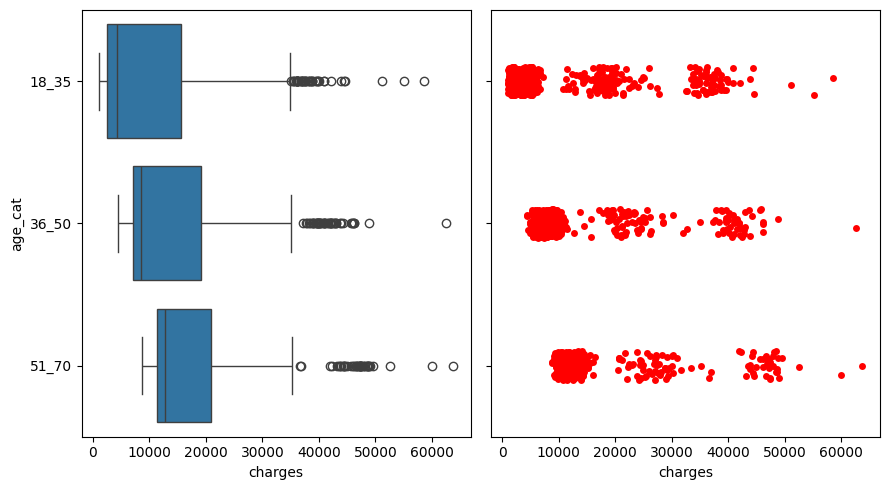

In [7]:
fig, ax = plt.subplots(1,2,
                      figsize=(9,5),
                      sharey=True)
sns.boxplot(df_clean, x='charges', y='age_cat', ax=ax[0])
sns.stripplot(df_clean, x='charges', y='age_cat', color='red', ax=ax[1])
fig.tight_layout()

<Axes: title={'center': 'charges'}, xlabel='bmi_cat'>

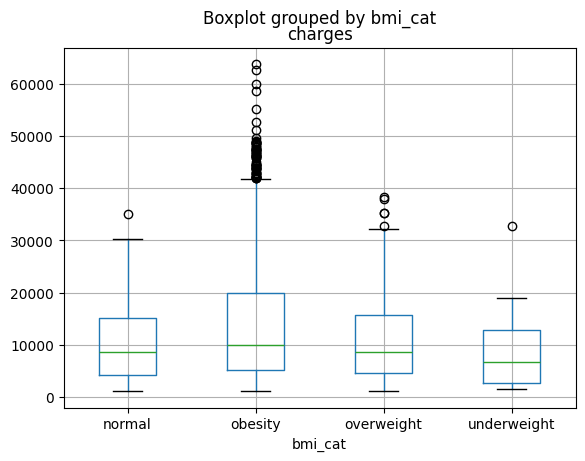

In [8]:
df_clean.boxplot('charges', by='bmi_cat')

# Analyse

## Analyse Age/charges


In [9]:

a,b,r,p,_ = stats.linregress(df_clean.age, df_clean.charges)

a,b,r,p



(257.2297175179149,
 3190.0217210318224,
 0.2983082125097864,
 6.975748762691313e-29)

Nous remarquons une forte corrélation entre l'age et les charges, le calcul de la p-value et du coefficient de Peason l'attestent

<Figure size 640x480 with 0 Axes>

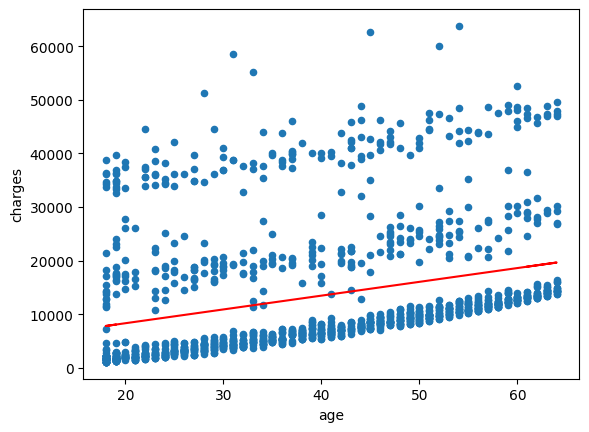

In [10]:
plt.figure(1)
df_clean.plot('age','charges',kind='scatter')
plt.figure(2)
plt.plot(df_clean.age, a*df_clean.age + b , 'red')


## Analyse BMI/charges

In [11]:
a,b,r,p,_ = stats.linregress(df_clean.bmi, df_clean.charges)

a,b,r,p


(393.8558912099734,
 1202.1403670662148,
 0.1984008312262494,
 2.4680404264512973e-13)

<Figure size 640x480 with 0 Axes>

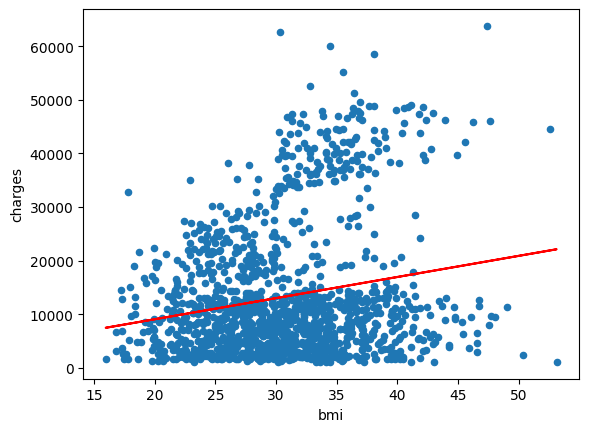

In [12]:
plt.figure(1)
df_clean.plot('bmi','charges',kind='scatter')
plt.figure(2)
plt.plot(df_clean.bmi, a*df_clean.bmi + b , 'red')


## Analyse Smoker/Charges


Anova est un modèle d'analyse qui permet de comparer la variation d'une variable qualitative et d'une variable quantitative

<Axes: title={'center': 'charges'}, xlabel='smoker'>

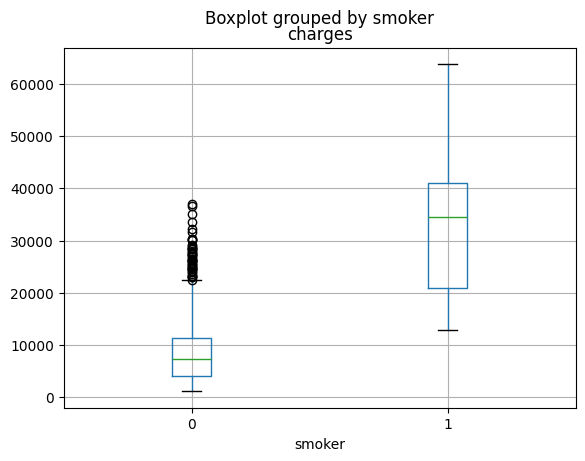

In [13]:
# boxplot

df_clean.boxplot('charges', by='smoker')

Nous soulignons une varaition significative de la médiane que l'observation soit fumeuse ou non. L'observation de plusieurs valeurs atypiques laisse penser que d'autres variables ont une influence significative avec la charge.
Nous allons vérifier avec le modèle Anova cad l'analyse de la variance.

In [14]:
statf,pvalue = stats.f_oneway(df_clean.charges[df_clean.smoker==1],df_clean.charges[df_clean.smoker==0])
statf,pvalue

(2175.7368631272116, 1.4067220949358597e-282)

Nous observons une pvalue très faible, ainsi nus rejetons l'hypothèse nulle. Cela veut dire qu'il y a un effet dans les données qui n'est pas dû au hasard.

## Analyse Southeast/BMI

<Axes: title={'center': 'bmi'}, xlabel='is_southeast'>

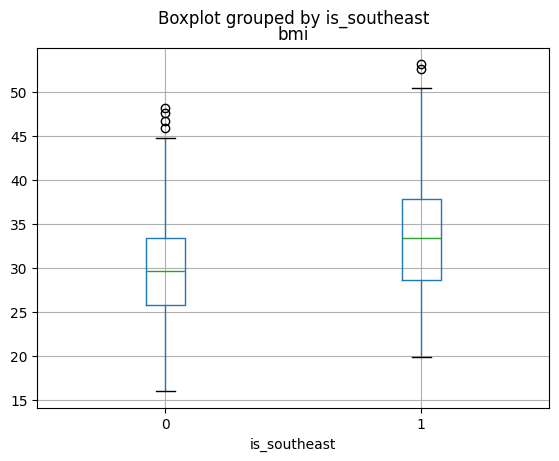

In [15]:
# boxplot

df_clean.boxplot('bmi', by='is_southeast')

In [16]:
statf,pvalue = stats.f_oneway(df_clean.bmi[df_clean.is_southeast == 1], df_clean.bmi[df_clean.is_southeast == 0])
statf,pvalue

(105.0218465125994, 8.933277252354888e-24)

# Analyse bivariée